# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.ticker
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")

### Constants

In [3]:
spain_region_country_name = "Spain"
spain_region_country_code = "ES"

daily_summary_days = 7 * 3
daily_plot_days = 7 * 2
tek_dumps_load_limit = daily_summary_days + 1

### COVID-19 Cases

In [4]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")

radar_covid_countries = {spain_region_country_name}

confirmed_df = confirmed_df[confirmed_df["Country_EN"].isin(radar_covid_countries)]
confirmed_df = confirmed_df[pd.isna(confirmed_df.Region)]
confirmed_df.head()

,Country_EN,Country_ES,Country_IT,Region,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2020-09-27,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,2020-10-06
233,Spain,España,Spagna,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,716481.0,748266.0,748266.0,769188.0,778607.0,789932.0,789932.0,789932.0,813412.0,825410.0


In [5]:
confirmed_country_columns = list(filter(lambda x: x.startswith("Country_"), confirmed_df.columns))
confirmed_regional_columns = confirmed_country_columns + ["Region"]
confirmed_df.drop(columns=confirmed_regional_columns, inplace=True)
confirmed_df.head()

,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,...,2020-09-27,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,2020-10-06
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,716481.0,748266.0,748266.0,769188.0,778607.0,789932.0,789932.0,789932.0,813412.0,825410.0


In [6]:
confirmed_df = confirmed_df.sum().to_frame()
confirmed_df.tail()

,0
2020-10-02,789932.0
2020-10-03,789932.0
2020-10-04,789932.0
2020-10-05,813412.0
2020-10-06,825410.0


In [7]:
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["covid_cases"] = confirmed_df.new_cases.rolling(7).mean().round()
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,covid_cases
253,2020-10-02,789932.0,11325.0,10493.0
254,2020-10-03,789932.0,0.0,10493.0
255,2020-10-04,789932.0,0.0,10493.0
256,2020-10-05,813412.0,23480.0,9307.0
257,2020-10-06,825410.0,11998.0,11021.0


In [8]:
extraction_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_date]
extraction_previous_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_previous_date].copy()

if extraction_date_confirmed_df.empty and \
    not extraction_previous_date_confirmed_df.empty:
        extraction_previous_date_confirmed_df["sample_date_string"] = extraction_date
        extraction_previous_date_confirmed_df["new_cases"] = \
            extraction_previous_date_confirmed_df.covid_cases
        extraction_previous_date_confirmed_df["cumulative_cases"] = \
            extraction_previous_date_confirmed_df.new_cases + \
            extraction_previous_date_confirmed_df.cumulative_cases
        confirmed_df = confirmed_df.append(extraction_previous_date_confirmed_df)

confirmed_df["covid_cases"] = confirmed_df.covid_cases.fillna(0).astype(int)
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,covid_cases
254,2020-10-03,789932.0,0.0,10493
255,2020-10-04,789932.0,0.0,10493
256,2020-10-05,813412.0,23480.0,9307
257,2020-10-06,825410.0,11998.0,11021
257,2020-10-07,836431.0,11021.0,11021


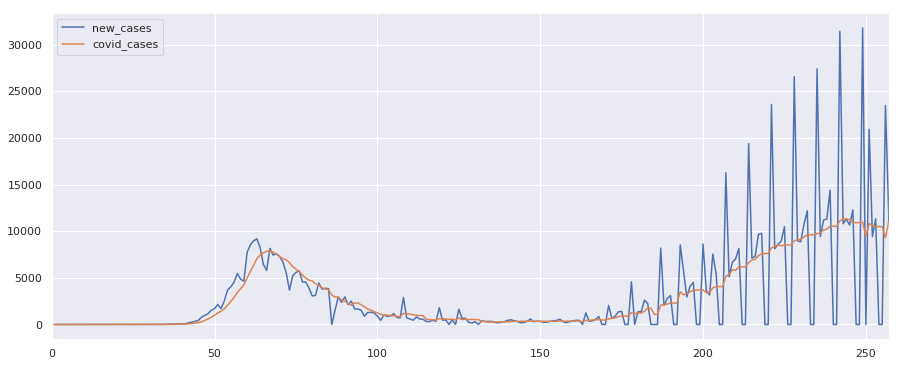

In [9]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [10]:
from Modules.RadarCOVID import radar_covid

raw_zip_paths = [
    "Data/TEKs/Raw/Current/RadarCOVID-TEKs-{sample_date}.zip",
    f"Data/TEKs/Raw/Daily/{extraction_date}/RadarCOVID-TEKs-{{sample_date}}.zip",
    f"Data/TEKs/Raw/Hourly/{extraction_date_with_hour}/RadarCOVID-TEKs-{{sample_date}}.zip",
]

multi_region_exposure_keys_df = \
    radar_covid.download_last_radar_covid_exposure_keys(
        days=14, save_raw_zip_path=raw_zip_paths)
multi_region_exposure_keys_df.head()

,sample_datetime,sample_date_string,source_url,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level
0,2020-10-06 00:00:00+00:00,2020-10-06,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,V1,214,1.2.840.10045.4.3.2,261c2a54-c81c-9242-0e5d-b7b40877b6a4,2669904,138,0
1,2020-10-06 00:00:00+00:00,2020-10-06,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,V1,214,1.2.840.10045.4.3.2,d3c8bf88-f3a3-1648-70d9-9ecd79961d27,2669904,136,0
2,2020-10-06 00:00:00+00:00,2020-10-06,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,V1,214,1.2.840.10045.4.3.2,2ed478e1-6fb4-7433-2ba5-5ddcaf3e7f8b,2669904,131,0
3,2020-10-06 00:00:00+00:00,2020-10-06,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,V1,214,1.2.840.10045.4.3.2,147e0750-186b-a384-fafa-03d371771102,2669904,127,0
4,2020-10-06 00:00:00+00:00,2020-10-06,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,V1,214,1.2.840.10045.4.3.2,5f565bea-2f35-2ae4-33ac-8b57e1283e59,2669904,121,0


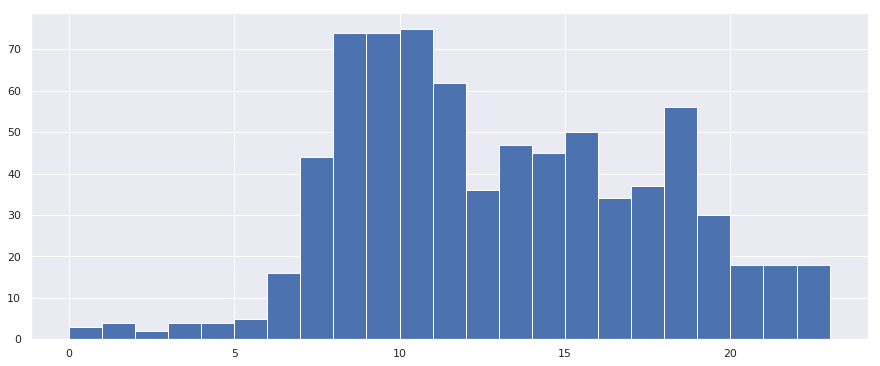

In [11]:
early_teks_df = multi_region_exposure_keys_df[
    multi_region_exposure_keys_df.rolling_period < radar_covid.maximum_key_rolling_period].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

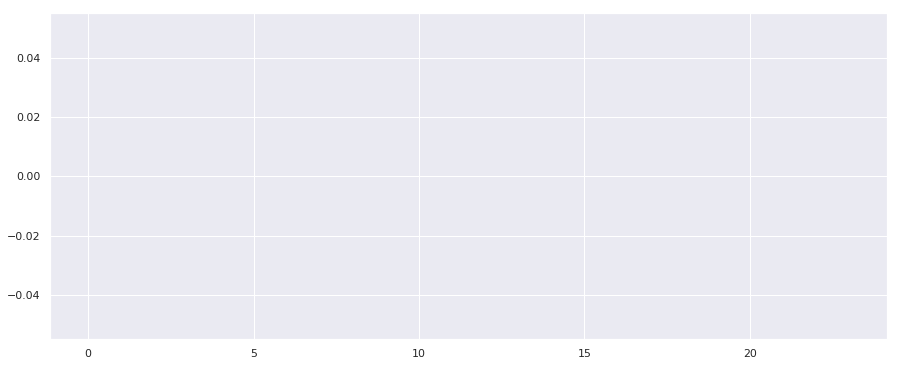

In [12]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [13]:
multi_region_exposure_keys_df = multi_region_exposure_keys_df[[
    "sample_date_string", "source_url", "region", "key_data"]]
multi_region_exposure_keys_df.head()

,sample_date_string,source_url,region,key_data
0,2020-10-06,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,261c2a54-c81c-9242-0e5d-b7b40877b6a4
1,2020-10-06,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,d3c8bf88-f3a3-1648-70d9-9ecd79961d27
2,2020-10-06,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,2ed478e1-6fb4-7433-2ba5-5ddcaf3e7f8b
3,2020-10-06,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,147e0750-186b-a384-fafa-03d371771102
4,2020-10-06,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,5f565bea-2f35-2ae4-33ac-8b57e1283e59


In [14]:
active_regions = \
    multi_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['ES']

In [15]:
multi_region_summary_df = multi_region_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_region_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
multi_region_summary_df.head()

,shared_teks_by_generation_date
region,ES
sample_date_string,
2020-10-06,62
2020-10-05,109
2020-10-04,179
2020-10-03,213
2020-10-02,265


In [16]:
multi_region_without_spain_exposure_keys_df = \
    multi_region_exposure_keys_df[multi_region_exposure_keys_df.region != spain_region_country_code]
active_regions_excluding_spain = \
    multi_region_without_spain_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions_excluding_spain

[]

In [17]:
exposure_keys_summary_df = multi_region_exposure_keys_df[
    multi_region_exposure_keys_df.region == spain_region_country_code]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-10-06,62
2020-10-05,109
2020-10-04,179
2020-10-03,213
2020-10-02,265


### Dump API TEKs

In [18]:
tek_list_df = multi_region_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour
tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    "Data/TEKs/Current/RadarCOVID-TEKs.json",
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    "Data/TEKs/Daily/RadarCOVID-TEKs-" + extraction_date + ".json",
    lines=True, orient="records")
tek_list_df.to_json(
    "Data/TEKs/Hourly/RadarCOVID-TEKs-" + extraction_date_with_hour + ".json",
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-09-24,ES,"[630f880d-b806-d5aa-cbda-ea3dd467f5d9, e4d0219...",2020-10-07,2020-10-07@00
1,2020-09-25,ES,"[e0de6a38-be0e-13ec-546f-b33721bed8d9, 0a7415b...",2020-10-07,2020-10-07@00
2,2020-09-26,ES,"[005336e4-85e4-105d-150f-bae8db04b82d, f4236bc...",2020-10-07,2020-10-07@00
3,2020-09-27,ES,"[e258ba78-d53f-9e28-86d1-035a49fc0a07, c460f92...",2020-10-07,2020-10-07@00
4,2020-09-28,ES,"[a3991105-3083-fb48-151c-1885a1a86a9a, 7910b66...",2020-10-07,2020-10-07@00


### Load TEK Dumps

In [19]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    paths = list(reversed(sorted(glob.glob(f"Data/TEKs/{mode}/RadarCOVID-TEKs-*.json"))))
    if limit:
        paths = paths[:limit]
    for path in paths:
        logging.info(f"Loading TEKs from '{path}'...")
        iteration_extracted_teks_df = pd.read_json(path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [20]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=spain_region_country_code,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date
0,ES,2020-09-24,"[630f880d-b806-d5aa-cbda-ea3dd467f5d9, e4d0219...",2020-10-07
1,ES,2020-09-25,"[e0de6a38-be0e-13ec-546f-b33721bed8d9, 0a7415b...",2020-10-07
2,ES,2020-09-26,"[005336e4-85e4-105d-150f-bae8db04b82d, f4236bc...",2020-10-07
3,ES,2020-09-27,"[e258ba78-d53f-9e28-86d1-035a49fc0a07, c460f92...",2020-10-07
4,ES,2020-09-28,"[a3991105-3083-fb48-151c-1885a1a86a9a, 7910b66...",2020-10-07


In [21]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-10-06,62
2020-10-05,109
2020-10-04,179
2020-10-03,213
2020-10-02,265


### Daily New TEKs

In [22]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-09-16,"{fd47cb02-d468-a878-0d2e-75afc6e0d250, bd36391..."
2020-09-17,"{fd47cb02-d468-a878-0d2e-75afc6e0d250, bd36391..."
2020-09-18,"{fd47cb02-d468-a878-0d2e-75afc6e0d250, bd36391..."
2020-09-19,"{fd47cb02-d468-a878-0d2e-75afc6e0d250, bd36391..."
2020-09-20,"{41e615a4-33db-7b6b-6ddb-a388384b134b, fd47cb0..."


In [23]:
today_new_teks_set_df = tek_list_df.diff()
try:
    today_new_teks_set = today_new_teks_set_df[
        today_new_teks_set_df.index == extraction_date].tek_list.item()
except ValueError:
    today_new_teks_set = set()
today_new_teks_df = daily_extracted_teks_df[
    daily_extracted_teks_df.extraction_date == extraction_date].copy()
today_new_teks_df["today_teks"] = \
    today_new_teks_df.tek_list.apply(lambda x: set(x).intersection(today_new_teks_set))
today_new_teks_df["today_teks_by_generation_date"] = \
    today_new_teks_df.today_teks.apply(len)
today_new_teks_df = today_new_teks_df[["sample_date", "today_teks_by_generation_date"]]
today_new_teks_df.set_index("sample_date", inplace=True)
today_new_teks_df.tail()

<ipython-input-23-4d18d86f3c3b>:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  today_new_teks_set = today_new_teks_set_df[


,today_teks_by_generation_date
sample_date,
2020-10-02,1
2020-10-03,1
2020-10-04,1
2020-10-05,1
2020-10-06,2


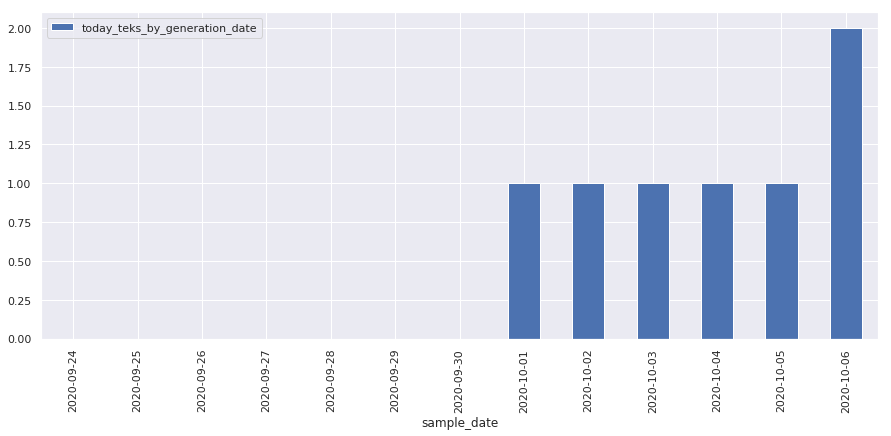

In [24]:
today_new_teks_df.plot.bar()

In [25]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
17,2020-10-03,324.0
18,2020-10-04,331.0
19,2020-10-05,273.0
20,2020-10-06,233.0
21,2020-10-07,7.0


In [26]:
estimated_shared_diagnoses_df = daily_extracted_teks_df.copy()
estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(estimated_shared_diagnoses_df.sample_date) + datetime.timedelta(1)
estimated_shared_diagnoses_df["extraction_date"] = pd.to_datetime(estimated_shared_diagnoses_df.extraction_date)
estimated_shared_diagnoses_df["sample_date"] = pd.to_datetime(estimated_shared_diagnoses_df.sample_date)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,new_sample_extraction_date
0,ES,2020-09-24,"[630f880d-b806-d5aa-cbda-ea3dd467f5d9, e4d0219...",2020-10-07,2020-09-25
1,ES,2020-09-25,"[e0de6a38-be0e-13ec-546f-b33721bed8d9, 0a7415b...",2020-10-07,2020-09-26
2,ES,2020-09-26,"[005336e4-85e4-105d-150f-bae8db04b82d, f4236bc...",2020-10-07,2020-09-27
3,ES,2020-09-27,"[e258ba78-d53f-9e28-86d1-035a49fc0a07, c460f92...",2020-10-07,2020-09-28
4,ES,2020-09-28,"[a3991105-3083-fb48-151c-1885a1a86a9a, 7910b66...",2020-10-07,2020-09-29


In [27]:
# Sometimes TEKs from the same day are uploaded, we do not count them as new TEK devices:
same_day_tek_list_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.sample_date == estimated_shared_diagnoses_df.extraction_date].copy()
same_day_tek_list_df = same_day_tek_list_df[["extraction_date", "tek_list"]].rename(
    columns={"tek_list": "same_day_tek_list"})
same_day_tek_list_df.head()

,extraction_date,same_day_tek_list
13,2020-10-06,"[2ed478e1-6fb4-7433-2ba5-5ddcaf3e7f8b, 147e075..."
13,2020-10-05,"[40e3b870-b9ea-392d-8e17-4e6ac12af668, 39beaeb..."
13,2020-10-04,"[66abf67e-ed33-e011-f22f-0d113b889269, e46ca4e..."
13,2020-10-03,"[18382d12-db65-c185-fdf0-f4c82fb9896f, f0809f0..."
13,2020-10-02,"[8e2e9a10-3c39-a858-c313-2eb01e99e5d1, 6047e2f..."


In [28]:
shared_teks_uploaded_on_generation_date_df = same_day_tek_list_df.rename(
    columns={
        "extraction_date": "sample_date_string",
        "same_day_tek_list": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date = \
 shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date.apply(len)
shared_teks_uploaded_on_generation_date_df.head()
shared_teks_uploaded_on_generation_date_df["sample_date_string"] = \
    shared_teks_uploaded_on_generation_date_df.sample_date_string.dt.strftime("%Y-%m-%d")
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
13,2020-10-06,60
13,2020-10-05,52
13,2020-10-04,76
13,2020-10-03,69
13,2020-10-02,72


In [29]:
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.new_sample_extraction_date == estimated_shared_diagnoses_df.extraction_date]
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,new_sample_extraction_date
12,ES,2020-10-06,"[261c2a54-c81c-9242-0e5d-b7b40877b6a4, d3c8bf8...",2020-10-07,2020-10-07
12,ES,2020-10-05,"[1e645e90-926b-525d-8f28-b2741ffff1f1, 2914f5a...",2020-10-06,2020-10-06
12,ES,2020-10-04,"[9940291e-5783-637d-8643-023752897f51, 7f4fc53...",2020-10-05,2020-10-05
12,ES,2020-10-03,"[8dcccda4-6aed-2740-e9a2-1ca9b693b5a4, 7a669c9...",2020-10-04,2020-10-04
12,ES,2020-10-02,"[fc986875-6d7c-40ff-a9eb-0584fe73231a, 29a7d8a...",2020-10-03,2020-10-03


In [30]:
same_day_tek_list_df["extraction_date"] = \
    same_day_tek_list_df.extraction_date + datetime.timedelta(1)
estimated_shared_diagnoses_df = \
    estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
estimated_shared_diagnoses_df["same_day_tek_list"] = \
    estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,new_sample_extraction_date,same_day_tek_list
0,ES,2020-10-06,"[261c2a54-c81c-9242-0e5d-b7b40877b6a4, d3c8bf8...",2020-10-07,2020-10-07,"[2ed478e1-6fb4-7433-2ba5-5ddcaf3e7f8b, 147e075..."
1,ES,2020-10-05,"[1e645e90-926b-525d-8f28-b2741ffff1f1, 2914f5a...",2020-10-06,2020-10-06,"[40e3b870-b9ea-392d-8e17-4e6ac12af668, 39beaeb..."
2,ES,2020-10-04,"[9940291e-5783-637d-8643-023752897f51, 7f4fc53...",2020-10-05,2020-10-05,"[66abf67e-ed33-e011-f22f-0d113b889269, e46ca4e..."
3,ES,2020-10-03,"[8dcccda4-6aed-2740-e9a2-1ca9b693b5a4, 7a669c9...",2020-10-04,2020-10-04,"[18382d12-db65-c185-fdf0-f4c82fb9896f, f0809f0..."
4,ES,2020-10-02,"[fc986875-6d7c-40ff-a9eb-0584fe73231a, 29a7d8a...",2020-10-03,2020-10-03,"[8e2e9a10-3c39-a858-c313-2eb01e99e5d1, 6047e2f..."


In [31]:
estimated_shared_diagnoses_df.set_index("extraction_date", inplace=True)
estimated_shared_diagnoses_df["shared_diagnoses"] = estimated_shared_diagnoses_df.apply(
    lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1).copy()
estimated_shared_diagnoses_df.reset_index(inplace=True)
estimated_shared_diagnoses_df.rename(columns={
    "extraction_date": "sample_date_string"}, inplace=True)
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[["sample_date_string", "shared_diagnoses"]]
estimated_shared_diagnoses_df["sample_date_string"] = estimated_shared_diagnoses_df.sample_date_string.dt.strftime("%Y-%m-%d")
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
0,2020-10-07,2
1,2020-10-06,56
2,2020-10-05,69
3,2020-10-04,78
4,2020-10-03,76


### Hourly New TEKs

In [32]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=spain_region_country_code, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
0,ES,2020-09-24,"[630f880d-b806-d5aa-cbda-ea3dd467f5d9, e4d0219...",2020-10-07,2020-10-07@00
1,ES,2020-09-25,"[e0de6a38-be0e-13ec-546f-b33721bed8d9, 0a7415b...",2020-10-07,2020-10-07@00
2,ES,2020-09-26,"[005336e4-85e4-105d-150f-bae8db04b82d, f4236bc...",2020-10-07,2020-10-07@00
3,ES,2020-09-27,"[e258ba78-d53f-9e28-86d1-035a49fc0a07, c460f92...",2020-10-07,2020-10-07@00
4,ES,2020-09-28,"[a3991105-3083-fb48-151c-1885a1a86a9a, 7910b66...",2020-10-07,2020-10-07@00


In [33]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2020-10-06@00,0
1,2020-10-06@01,0
2,2020-10-06@02,16
3,2020-10-06@03,0
4,2020-10-06@04,1


In [34]:
hourly_estimated_shared_diagnoses_df = hourly_extracted_teks_df.copy()
hourly_estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.sample_date) + datetime.timedelta(1)
hourly_estimated_shared_diagnoses_df["extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.extraction_date)

hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[
    hourly_estimated_shared_diagnoses_df.new_sample_extraction_date ==
    hourly_estimated_shared_diagnoses_df.extraction_date]
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = hourly_estimated_shared_diagnoses_df.apply(
    lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1)
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.sort_values("extraction_date_with_hour").copy()
hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = hourly_estimated_shared_diagnoses_df \
    .groupby("extraction_date").shared_diagnoses.diff() \
    .fillna(0).astype(int)

hourly_estimated_shared_diagnoses_df.set_index("extraction_date_with_hour", inplace=True)
hourly_estimated_shared_diagnoses_df.reset_index(inplace=True)
hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[[
    "extraction_date_with_hour", "shared_diagnoses"]]
hourly_estimated_shared_diagnoses_df.head()

,extraction_date_with_hour,shared_diagnoses
0,2020-10-06@00,0
1,2020-10-06@01,0
2,2020-10-06@02,16
3,2020-10-06@03,0
4,2020-10-06@04,0


In [35]:
hourly_summary_df = hourly_new_tek_count_df.merge(
    hourly_estimated_shared_diagnoses_df, on=["extraction_date_with_hour"], how="outer")
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date,shared_diagnoses
datetime_utc,,,
2020-10-06 01:00:00,2020-10-06@01,0,0
2020-10-06 02:00:00,2020-10-06@02,16,16
2020-10-06 03:00:00,2020-10-06@03,0,0
2020-10-06 04:00:00,2020-10-06@04,1,0
2020-10-06 05:00:00,2020-10-06@05,0,0


### Data Merge

In [36]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-10-06,62.0,233.0
1,2020-10-05,109.0,273.0
2,2020-10-04,179.0,331.0
3,2020-10-03,213.0,324.0
4,2020-10-02,265.0,299.0


In [37]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2020-10-06,62.0,233.0,60.0
1,2020-10-05,109.0,273.0,52.0
2,2020-10-04,179.0,331.0,76.0
3,2020-10-03,213.0,324.0,69.0
4,2020-10-02,265.0,299.0,72.0


In [38]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-10-06,62.0,233.0,60.0,56.0
1,2020-10-05,109.0,273.0,52.0,69.0
2,2020-10-04,179.0,331.0,76.0,78.0
3,2020-10-03,213.0,324.0,69.0,76.0
4,2020-10-02,265.0,299.0,72.0,72.0


In [39]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-09-17,625651.0,11291.0,10215,139.0,63.0,NaN,29.0
1,2020-09-18,640040.0,14389.0,10531,165.0,138.0,1.0,52.0
2,2020-09-19,640040.0,0.0,10531,203.0,90.0,2.0,39.0
3,2020-09-20,640040.0,0.0,10531,218.0,116.0,NaN,45.0
4,2020-09-21,671468.0,31428.0,11105,268.0,190.0,NaN,45.0


In [40]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
sample_date,,,,,,,
2020-10-07,836431.0,11021.0,11021,NaN,7.0,NaN,2.0
2020-10-06,825410.0,11998.0,11021,62.0,233.0,60.0,56.0
2020-10-05,813412.0,23480.0,9307,109.0,273.0,52.0,69.0
2020-10-04,789932.0,0.0,10493,179.0,331.0,76.0,78.0
2020-10-03,789932.0,0.0,10493,213.0,324.0,69.0,76.0


In [41]:
result_summary_df = result_summary_df.fillna(0).astype(int)
result_summary_df["teks_per_shared_diagnosis"] = \
    result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses
result_summary_df["shared_diagnoses_per_covid_case"] = \
    result_summary_df.shared_diagnoses / result_summary_df.covid_cases
result_summary_df.head(daily_plot_days)

,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,,,,
2020-10-07,836431,11021,11021,0,7,0,2,3.500000,0.000181
2020-10-06,825410,11998,11021,62,233,60,56,4.160714,0.005081
2020-10-05,813412,23480,9307,109,273,52,69,3.956522,0.007414
2020-10-04,789932,0,10493,179,331,76,78,4.243590,0.007434
2020-10-03,789932,0,10493,213,324,69,76,4.263158,0.007243
2020-10-02,789932,11325,10493,265,299,72,72,4.152778,0.006862
2020-10-01,778607,9419,10628,308,367,75,74,4.959459,0.006963
2020-09-30,769188,20922,10805,290,271,55,51,5.313725,0.004720
2020-09-29,748266,0,9428,262,178,32,44,4.045455,0.004667


In [42]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)
weekly_result_summary_df = weekly_result_summary_df.fillna(0).astype(int)
weekly_result_summary_df["teks_per_shared_diagnosis"] = \
    weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses
weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
    weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases
weekly_result_summary_df.head()

,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,
2020-10-07,73456,1136,1834,427,4.295082,0.005813
2020-10-06,73240,1426,2098,476,4.407563,0.006499
2020-10-05,71647,1626,2043,464,4.403017,0.006476
2020-10-04,73311,1783,1981,449,4.412027,0.006125
2020-10-03,73738,1918,2099,479,4.382046,0.006496


In [43]:
last_7_days_summary = weekly_result_summary_df.to_dict(orient="records")[0]
last_7_days_summary

{'covid_cases': 73456,
 'shared_teks_by_generation_date': 1136,
 'shared_teks_by_upload_date': 1834,
 'shared_diagnoses': 427,
 'teks_per_shared_diagnosis': 4.295081967213115,
 'shared_diagnoses_per_covid_case': 0.005813003702896972}

## Report Results

In [44]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "datetime_utc": "Timestamp (UTC)",
    "covid_cases": "COVID-19 Cases (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases Which Shared Diagnosis)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date",
}

In [45]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [46]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,COVID-19 Cases (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared TEKs Uploaded on Generation Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases Which Shared Diagnosis)
Sample Date (UTC),,,,,,,
2020-10-07,11021,0,7,0,2,3.500000,0.000181
2020-10-06,11021,62,233,60,56,4.160714,0.005081
2020-10-05,9307,109,273,52,69,3.956522,0.007414
2020-10-04,10493,179,331,76,78,4.243590,0.007434
2020-10-03,10493,213,324,69,76,4.263158,0.007243
2020-10-02,10493,265,299,72,72,4.152778,0.006862
2020-10-01,10628,308,367,75,74,4.959459,0.006963
2020-09-30,10805,290,271,55,51,5.313725,0.004720
2020-09-29,9428,262,178,32,44,4.045455,0.004667


### Daily Summary Plots

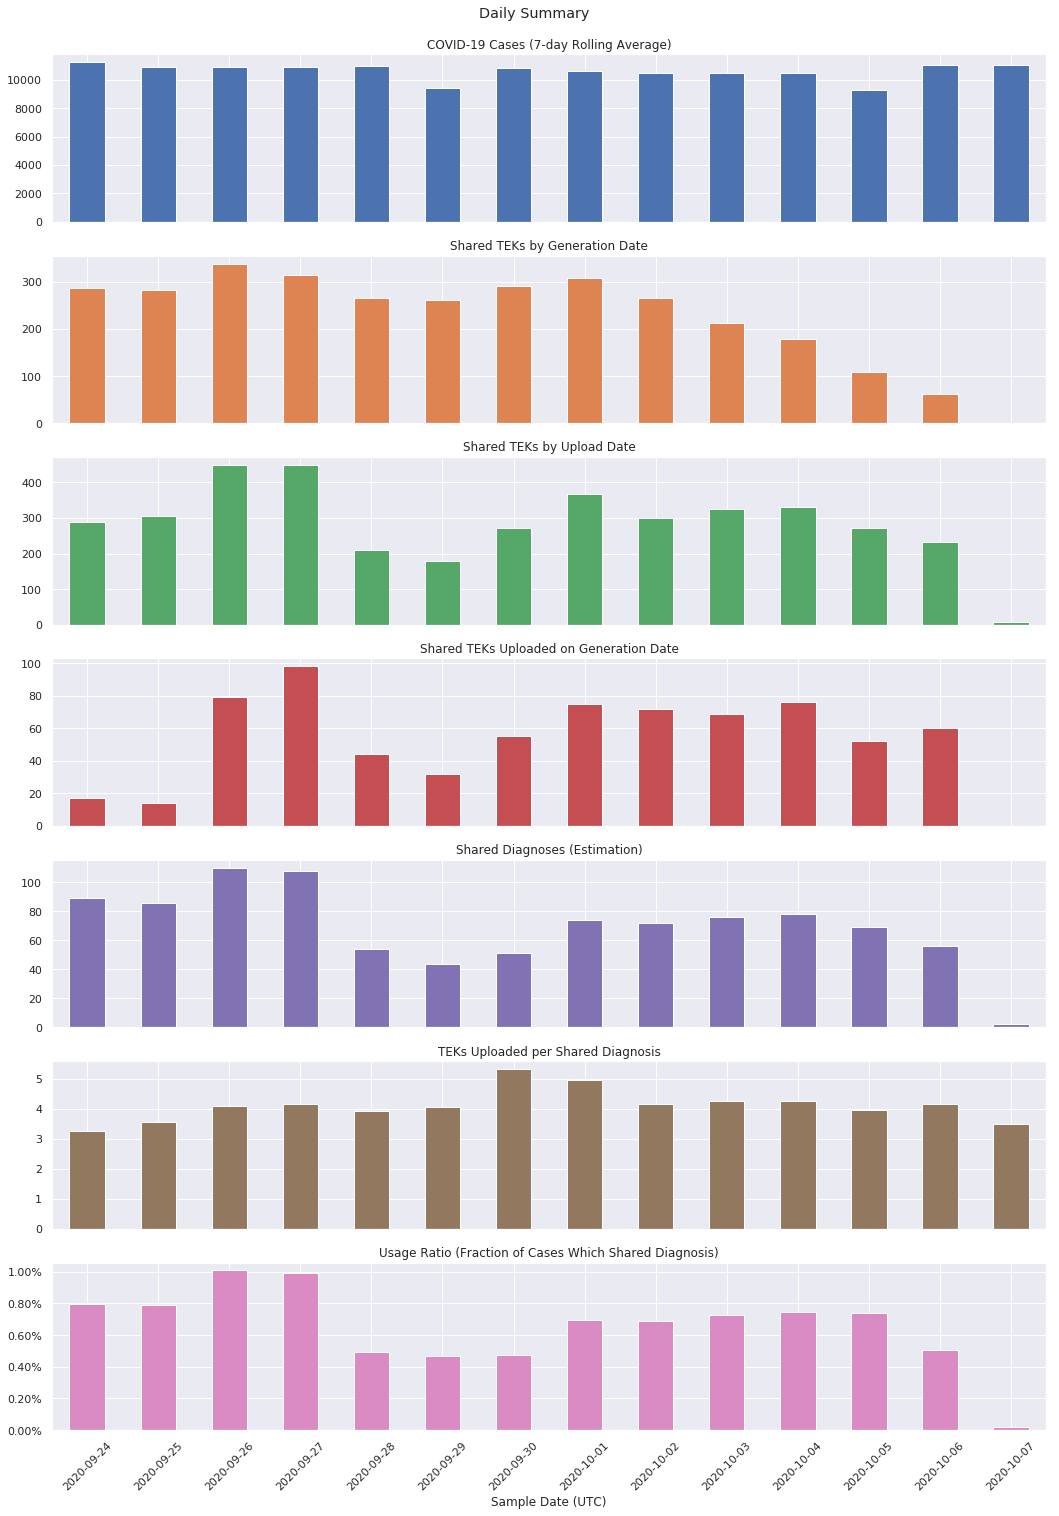

In [47]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Hourly Summary Plots 

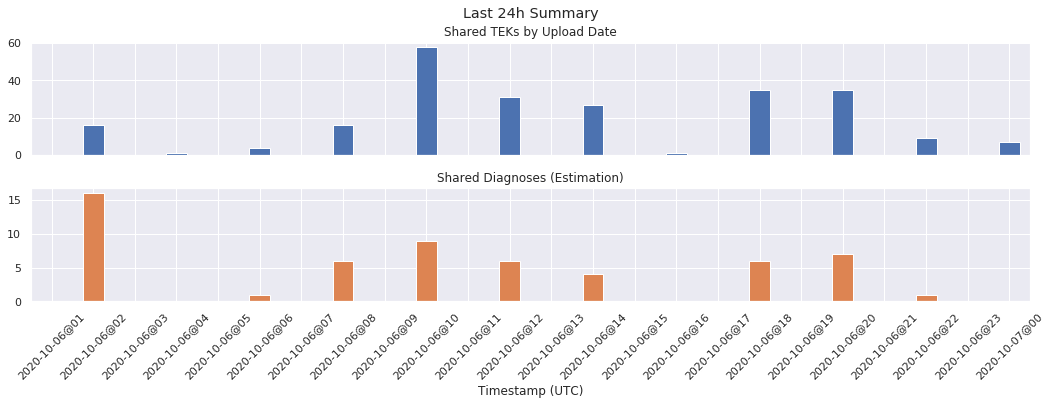

In [48]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [49]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [50]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(
        formatters={
            display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
            display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
        })

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.sum()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.sum()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.sum()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.sum()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.sum()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.sum()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)
shared_diagnoses_last_hour = \
    extraction_date_result_hourly_summary_df.shared_diagnoses.sum().astype(int)

In [51]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_region_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_region_summary_df)

### Save Results

In [52]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_region_summary_df.to_csv(report_resources_path_prefix + "Multi-Region-Summary-Table.csv")
_ = shutil.copyfile(summary_plots_image_path, report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(summary_table_image_path, report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(hourly_summary_plots_image_path, report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(multi_region_summary_table_image_path, report_resources_path_prefix + "Multi-Region-Summary-Table.png")

### Publish Results as JSON

In [53]:
summary_results_api_df = result_summary_df.reset_index()
summary_results_api_df["sample_date_string"] = \
    summary_results_api_df["sample_date"].dt.strftime("%Y-%m-%d")

summary_results = dict(
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=shared_diagnoses_last_hour,
    ),
    today=dict(
        covid_cases=covid_cases,
        shared_teks_by_generation_date=shared_teks_by_generation_date,
        shared_teks_by_upload_date=shared_teks_by_upload_date,
        shared_diagnoses=shared_diagnoses,
        teks_per_shared_diagnosis=teks_per_shared_diagnosis,
        shared_diagnoses_per_covid_case=shared_diagnoses_per_covid_case,
    ),
    last_7_days=last_7_days_summary,
    daily_results=summary_results_api_df.to_dict(orient="records"))
summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [54]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    extraction_date_with_hour=extraction_date_with_hour)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [55]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    hourly_summary_plots_media = api.media_upload(hourly_summary_plots_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        hourly_summary_plots_media.media_id,
    ]

    status = textwrap.dedent(f"""
        #RadarCOVID Report – {extraction_date_with_hour}

        Today:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f} ({shared_diagnoses_last_hour:+d} last hour)
        - TEKs per Diagnosis: ≥{teks_per_shared_diagnosis:.1f}
        - Usage Ratio: ≤{shared_diagnoses_per_covid_case:.2%}

        Week:
        - Shared Diagnoses: ≤{last_7_days_summary["shared_diagnoses"]:.0f}
        - Usage Ratio: ≤{last_7_days_summary["shared_diagnoses_per_covid_case"]:.2%}

        More Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)